# HH.ru vacancies parser for market research 

In [ ]:
# For convert saalries in USD and EUR to RUR
!pip install forex-python

import requests
import json
import os
import time
import re
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from forex_python.converter import CurrencyRates
from google.colab import drive
from functools import lru_cache
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from datetime import datetime
from dateutil.relativedelta import relativedelta


nltk.download("stopwords")

# Connect to Google Drive
drive.mount('/content/drive/')

plt.style.use('fivethirtyeight')

In [ ]:
# HH endpoint
url = 'https://api.hh.ru'

# Google Drive directory for save results
!mkdir /Practicum/
!mkdir /Practicum/vacancies/

# You need to specify search parameters for HH API

In [122]:
# You need to specify search parameters for HH API

position_title = 'ml'

job_titles = [
    'Machine Learning Engineer',
    'Machine Learning Developer',
    'Research Engineer',
    'Data Scientist (ML)',
    'Data Scientist (Machine Learning)',
    'R&D Engineer',
    'Разработчик (Machine Learning)',
    'ML разработчик',
    'ML engineer',
    'ML developer',
    'Разработчик машинного обучения'
]

skills_synonyms = {
    'Machine Learning': 'ML',
    'Машинное обучение': 'ML' 
}

In [124]:
# These parameters do not need to be changed

date_from = (datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d')
date_to = datetime.today().strftime('%Y-%m-%d')

exp = ['noExperience','between1And3', 'between3And6', 'moreThan6']

gdrive_path = f'/content/drive/MyDrive/Practicum/{position_title}'

### Functions for wrap GET /vacancies request

In [4]:
def get_vacancies_params(text, dt_from, dt_to, exp, page=0, per_page=100) -> dict:
    '''Returns params dict for GET /vacancies request

    https://github.com/hhru/api/blob/master/docs/vacancies.md
    '''

    params = {
        'text':text,
        'date_from':dt_from,
        'date_to':dt_to,
        'experience':exp,
        'page':page,
        'per_page':per_page,
        'currency': 'RUR'
    }
    
    return params


def get_vacancies_text(job_titles: list) -> str:
    ''' Returns correct format text param for GET /vacancies request 
    '''

    job_titles = ' OR '.join([f'\'{str(elem)}\'' for elem in job_titles])
    
    return f'NAME:({job_titles})'


def get_vacancies_req(url, params) -> dict:
    '''Wrapper for GET /vacancies API request
    '''

    r = requests.get(url = f'{url}/vacancies', params = params)
    data = r.json()
    
    return data


def get_vacancy_by_id(id: int) -> dict:
    '''Wrapper for GET /vacancies/{vacancy_id} API request
    '''

    r = requests.get(url = f'{url}/vacancies/{id}')
    data = r.json()
    
    return data


def get_items_id(items: list) -> list:
    return [item['id'] for item in items]


def get_vacancies(job_titles, exp, date_from, date_to) -> pd.DataFrame:
    '''Main function which returns DataFrame with vacancies
    '''

    df = pd.DataFrame()
    text = get_vacancies_text(job_titles)

    for e in exp:
        print(f'\nFor Experience = \'{e}\'')

        params = get_vacancies_params(text, date_from, date_to, e)
        resp = get_vacancies_req(url, params)

        items_id = get_items_id(resp['items'])
        pages = resp['pages']

        # Send request for every page
        for page in tqdm(range(1, pages), position=0, 
                         desc='Step (1/2): page\'s process'):
            params = get_vacancies_params(text, date_from, date_to, e, page)
            resp = get_vacancies_req(url, params)

            items_id += get_items_id(resp['items'])
        
        # Send request for every vacancy
        items = [get_vacancy_by_id(id) for id in tqdm(items_id, position=0,
                                                      desc='Step (2/2): vacancies process')]
        df_items = pd.DataFrame(items)
        df_items['experience'] = e

        df = pd.concat([df, df_items])

    return df

### Collect parameters for GET /vacancies request and run request

In [ ]:
# And run request
df = get_vacancies(job_titles, exp, date_from, date_to)

# Save DataFrame with vacancies to the Google Disk
df.to_pickle(f'{gdrive_path}/{position_title}.pickle')

For Experience = 'noExperience'


Step (1/2): page's process: 0it [00:00, ?it/s]
Step (2/2): vacancies process: 100%|██████████| 23/23 [00:14<00:00,  1.55it/s]


For Experience = 'between1And3'


Step (1/2): page's process: 0it [00:00, ?it/s]
Step (2/2): vacancies process: 100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


For Experience = 'between3And6'


Step (1/2): page's process: 0it [00:00, ?it/s]
Step (2/2): vacancies process: 100%|██████████| 69/69 [00:46<00:00,  1.49it/s]


For Experience = 'moreThan6'


Step (1/2): page's process: 0it [00:00, ?it/s]
Step (2/2): vacancies process: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


### Load data from Google Drive and analyse it

In [270]:
df = pd.read_pickle(f'{gdrive_path}/{position_title}.pickle')

# Check parsing result

print(f'Count of vacancies: {len(df.index)}\n')
print('Example:')

df.iloc[0]

Count of vacancies: 170

Example:


id                                                                       52019209
premium                                                                     False
billing_type                               {'id': 'standard', 'name': 'Стандарт'}
relations                                                                      []
name                                                        Инженер-исследователь
insider_interview                                                            None
response_letter_required                                                    False
area                            {'id': '66', 'name': 'Нижний Новгород', 'url':...
salary                          {'from': 35000, 'to': None, 'currency': 'RUR',...
type                                           {'id': 'open', 'name': 'Открытая'}
address                                                                      None
allow_messages                                                               True
site            

### Data cleaning

In [ ]:
# choose right columns only
df = df[['id', 'published_at', 'name', 'area', 'salary', 'employer', 'type', 
         'experience', 'description', 'key_skills', 'alternate_url']]


# convert 'area' json to string
convert_area = lambda area: area['name'] if 'name' in area else np.nan
df['area'] = df['area'].apply(convert_area).astype('string')


# convert Employer name from json to strinng
convert_employer = lambda employer: employer['name'] if 'name' in employer else np.nan
df['employer'] = df['employer'].apply(convert_employer).astype('string')


# convert 'key_skills' to list
convert_skills = lambda skills: [skill['name'] if skill['name'] not in skills_synonyms else skills_synonyms[skill['name']] for skill in skills]
df['key_skills'] = df['key_skills'].apply(convert_skills)


# convert 'type' json to string
convert_type = lambda tp: tp['name'] if 'name' in tp else np.nan
df['type'] = df['type'].apply(convert_type).astype('string')


# convert other fields
df['id'] = df['id'].astype('int')
df['published_at'] =  pd.to_datetime(df['published_at'], format='%Y-%m-%dT%X%z')
df['name'] = df['name'].astype('string')
df['alternate_url'] = df['alternate_url'].astype('string')
df['description'] = df['description'].astype('string')

In [272]:
# convert experience field to new format

def convert_exp(exp: str) -> str:
    convert = {
        'noExperience': 'Junior (no experince)',
        'between1And3': 'Junior+ (1-3 years)',
        'between3And6': 'Middle (3-6 years)',
        'moreThan6': 'Senior (6+ years)',
    }

    if exp in convert:
        return convert[exp]
    else:
        return 'Other'


df['experience'] = df['experience'].apply(convert_exp).astype('string')

In [273]:
# convert Salaris to RUR

@lru_cache(maxsize=32)
def get_rate(currency: str):
    if currency in ['USD', 'EUR']:
        c = CurrencyRates()
        curr = c.get_rate('RUB', currency)

        if curr != 0:
            return 1 / curr

    return np.nan


def convert_salary(salary) -> tuple:
    salary_from, salary_to = np.nan, np.nan

    if salary != None:
        salary_from = salary['from'] if salary['from'] != None else np.nan
        salary_to = salary['to'] if salary['to'] != None else np.nan

        if salary['currency'] != 'RUR':
            rate = get_rate(salary['currency'])
            salary_from *= rate
            salary_to *= rate

    return (salary_from, salary_to)


df['salary'] = df['salary'].apply(convert_salary)
df[['salary_from', 'salary_to']] = pd.DataFrame(df['salary'].tolist(), index=df.index)
df.drop(columns=['salary'], inplace=True)

In [ ]:
# create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
CLEANR = re.compile('<.*?>') 


# Mystem doesn't work in Colab (https://github.com/nlpub/pymystem3/issues/28),
# Need this hint
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem


# preprocess function
def preprocess_text(text: str) -> str:
    # remove tags
    clean_text = re.sub(CLEANR, '', text)

    # remove numbers
    no_number_text = re.sub(r'\d+', '', clean_text)

    tokens = mystem.lemmatize(no_number_text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords \
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text


# convert description
df['description'] = df['description'].apply(preprocess_text)

In [275]:
# Show example with actualized data format and types
df.iloc[0]

id                                                        52019209
published_at                             2022-03-01 12:55:04+03:00
name                                         Инженер-исследователь
area                                               Нижний Новгород
employer                             ФКП Завод имени Я.М.Свердлова
type                                                      Открытая
experience                                   Junior (no experince)
description      обязанность проведение научный исследование за...
key_skills       [Способность работать с документами, Стремлени...
alternate_url                       https://hh.ru/vacancy/52019209
salary_from                                                35000.0
salary_to                                                      NaN
Name: 0, dtype: object

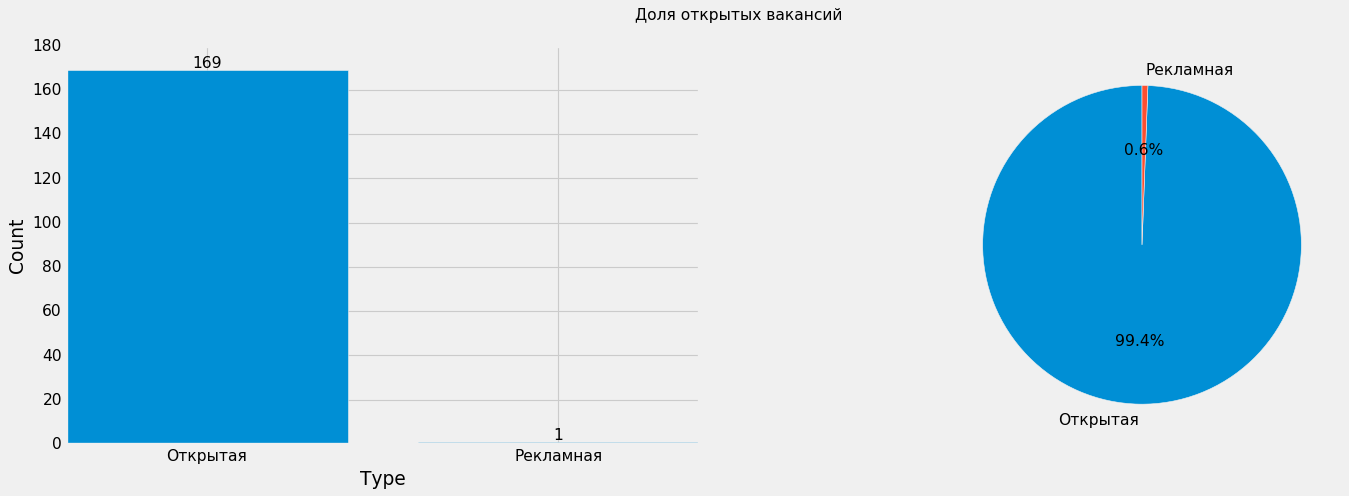

In [276]:
# Открытые вакансии

df_tmp = df.groupby(['type']).size()
x = df_tmp.index.to_list()
y = df_tmp.to_list()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Открытые вакансии', fontsize=14)


# в абсолютных величинах

axs[0].bar(x, y)
axs[0].set_xlabel('Type')
axs[0].set_ylabel('Count')

rects = axs[0].patches
labels = df_tmp.to_list()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0].text(
        rect.get_x() + rect.get_width() / 2, height, 
        label, ha='center', va='bottom')
    

df_tmp = df.groupby(['type']).size()
x = df_tmp.index.to_list()
y = df_tmp.to_list()

fig.suptitle('Доля открытых вакансий', fontsize=14)

patches, texts, pcts = axs[1].pie(y, labels=x, autopct='%.1f%%', 
                                  textprops={'size': 'medium'}, startangle=90)
plt.show()

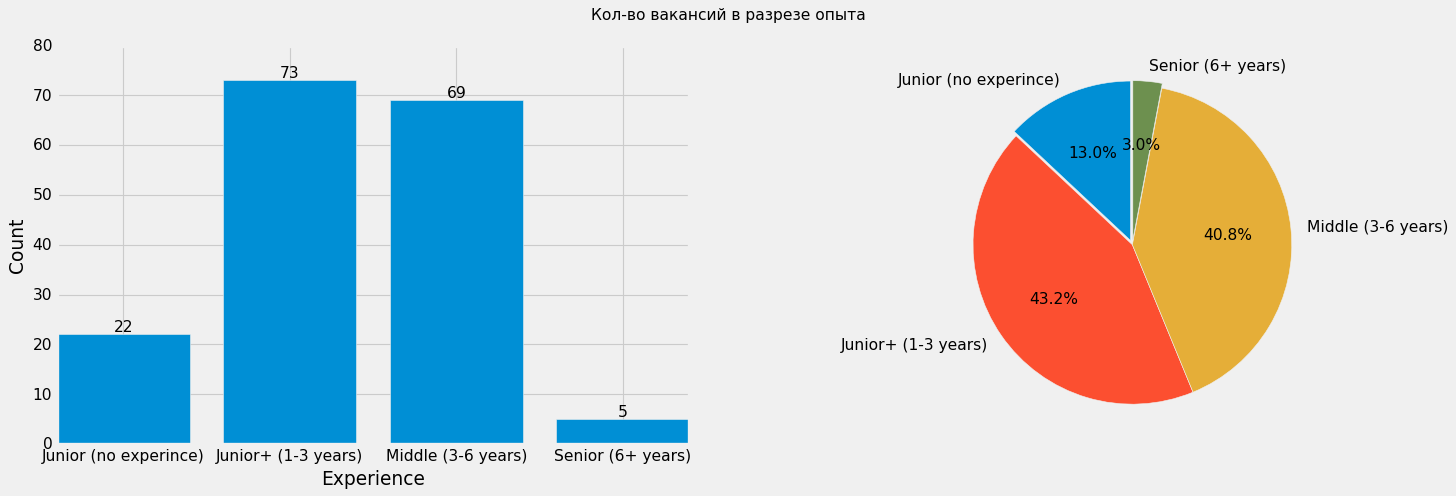

In [277]:
# Дальше работаем только с открытыми вакансиями

df = df[df['type'] == 'Открытая']


# Кол-во вакансий в разрезе опыта (jun, jun+, mid, sen)

df_tmp = df.groupby(['experience']).size()
x = df_tmp.index.to_list()
y = df_tmp.to_list()

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Кол-во вакансий в разрезе опыта', fontsize=14)


# в абсолютных величинах

axs[0].bar(x, y)
axs[0].set_xlabel('Experience')
axs[0].set_ylabel('Count')

rects = axs[0].patches
labels = df_tmp.to_list()

for rect, label in zip(rects, labels):
    height = rect.get_height()
    axs[0].text(
        rect.get_x() + rect.get_width() / 2, height, 
        label, ha='center', va='bottom')


# в относительных велечинах

patches, texts, pcts = axs[1].pie(y, labels=x, autopct='%.1f%%', 
                                  textprops={'size': 'medium'}, startangle=90,
                                  explode=[0.03, 0, 0, 0.03])

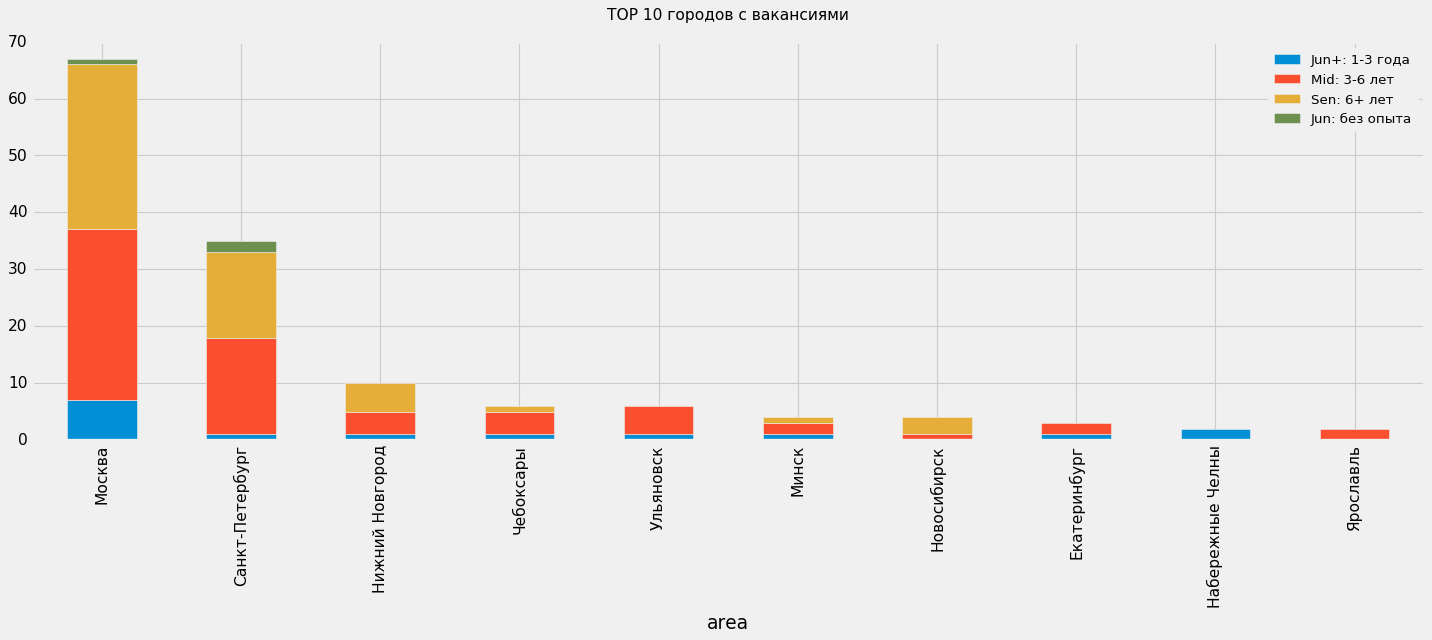

In [278]:
# TOP 10 городов с вакансиями

sorted_10 = df.groupby(['area']).size().sort_values(ascending=False)[:10]
grouped = df[df['area'].isin(sorted_10.index.tolist())].groupby(['area', 'experience']).size()
grouped.reindex(index=sorted_10.index, level=0).unstack().plot(kind='bar', 
                                                               figsize=(20, 6), 
                                                               stacked=True)

plt.title('TOP 10 городов с вакансиями', fontsize=14, pad=20)
plt.legend(['Jun+: 1-3 года', 'Mid: 3-6 лет', 'Sen: 6+ лет', 'Jun: без опыта'], fontsize=12)
plt.show()

In [279]:
# Распределение скиллов

def calculate_freq(df: pd.DataFrame, max_size=20) -> tuple:
    skills_dict = {}

    for row in df.iteritems():
        skills = row[1]
        for skill in skills:
            if skill in skills_dict:
                skills_dict[skill] += 1
            else:
                skills_dict[skill] = 1
    
    if len(skills_dict) < max_size:
        max_size = len(skills_dict)

    skills_dict = dict(sorted(skills_dict.items(), key=lambda item: item[1], 
                              reverse=True))
    
    return (list(skills_dict.keys())[:max_size][::-1], 
            list(skills_dict.values())[:max_size][::-1])

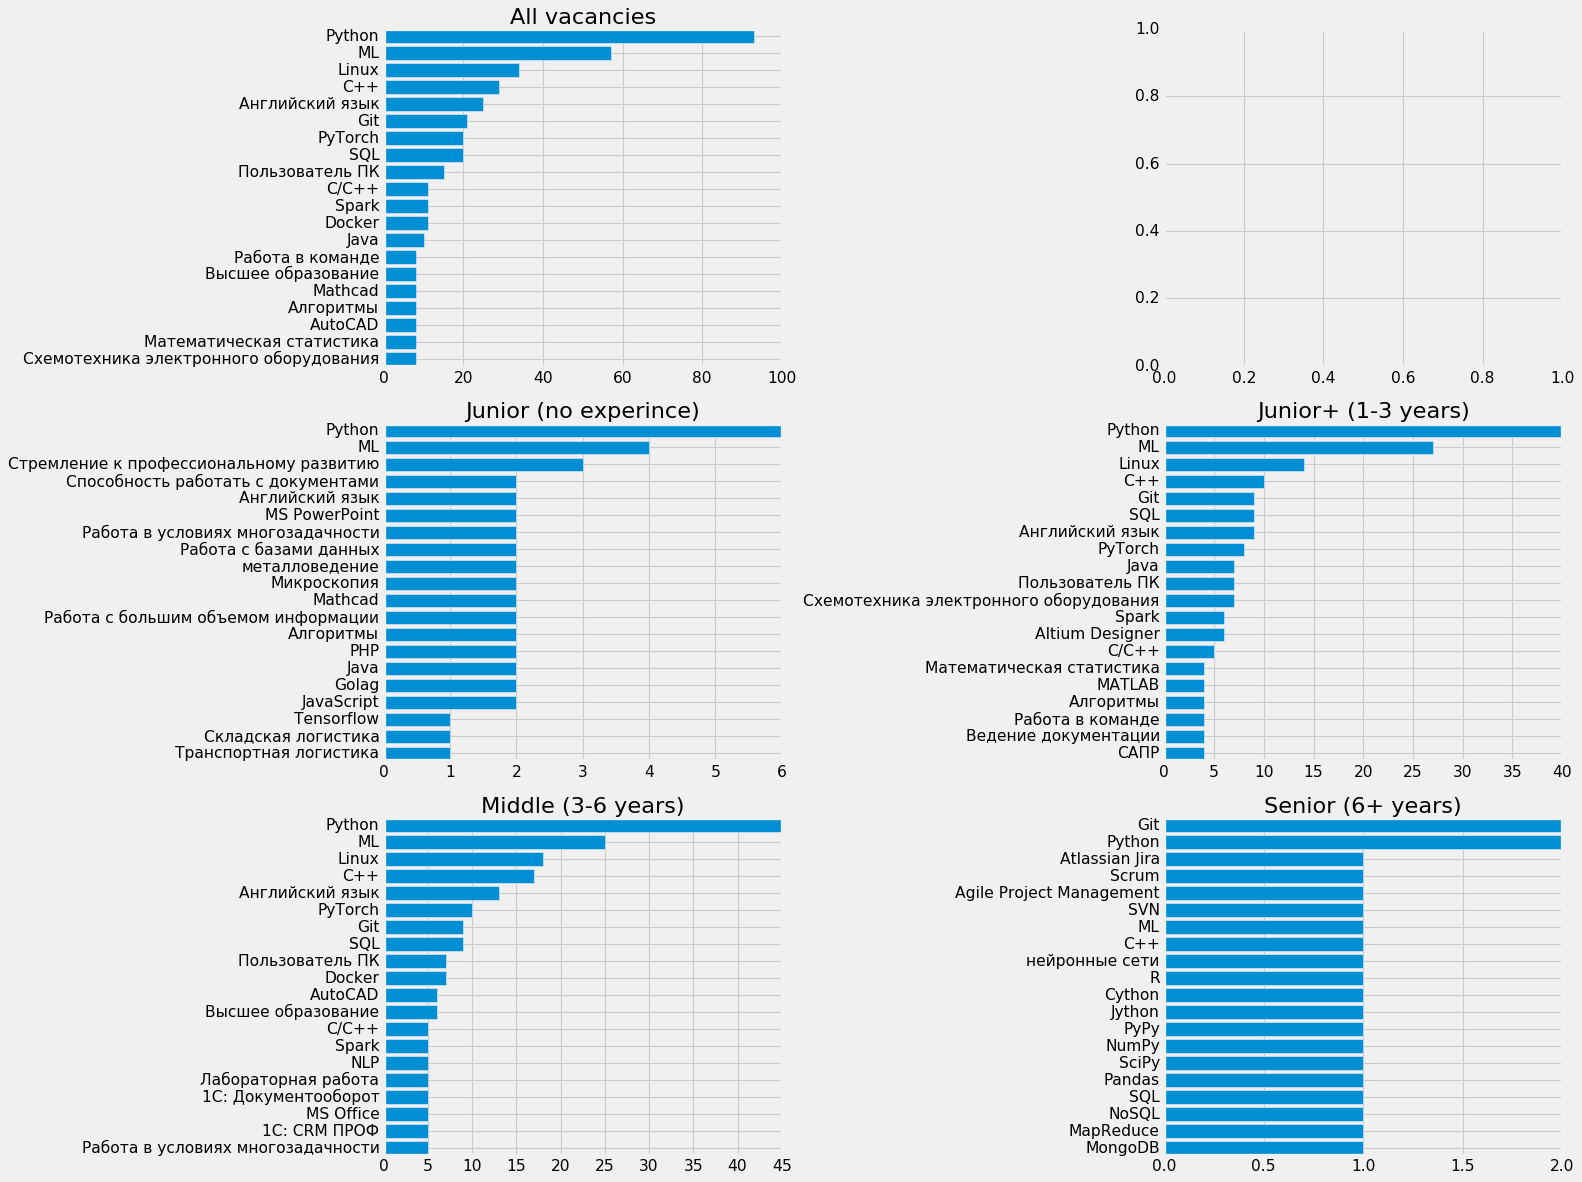

In [280]:
fig, axs = plt.subplots(3, 2, figsize=(20,15))
plt.title('TOP 5 нанимающих компаний', fontsize=14, pad=20)

# все вакансии
x, y = calculate_freq(df['key_skills'])
axs[0, 0].barh(x, y)
axs[0, 0].set_title('All vacancies')

# junior (без опыта работы)
x, y = calculate_freq(df[df['experience'] == 'Junior (no experince)']['key_skills'])
axs[1, 0].barh(x, y)
axs[1, 0].set_title('Junior (no experince)')

# junior+
x, y = calculate_freq(df[df['experience'] == 'Junior+ (1-3 years)']['key_skills'])
axs[1, 1].barh(x, y)
axs[1, 1].set_title('Junior+ (1-3 years)')

# middle
x, y = calculate_freq(df[df['experience'] == 'Middle (3-6 years)']['key_skills'])
axs[2, 0].barh(x, y)
axs[2, 0].set_title('Middle (3-6 years)')

# senior
x, y = calculate_freq(df[df['experience'] == 'Senior (6+ years)']['key_skills'])
axs[2, 1].barh(x, y)
axs[2, 1].set_title('Senior (6+ years)')

fig.tight_layout()

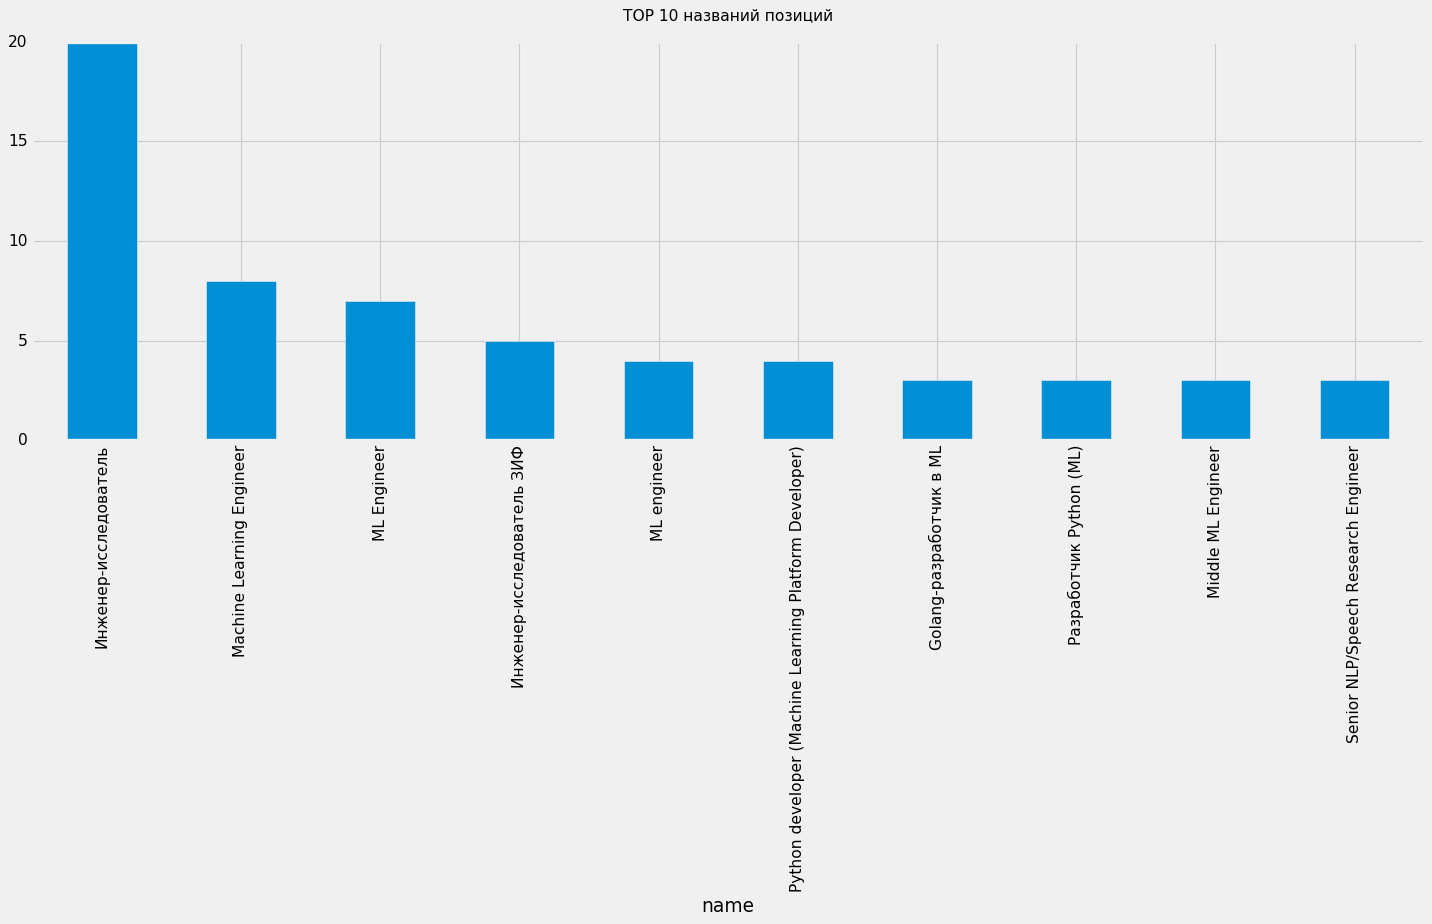

In [281]:
# TOP 10 названий позиций

x = df.groupby(['name']).size().sort_values(ascending=False)[:10].plot(kind='bar', 
                                                                       figsize=(20, 6), 
                                                                       stacked=True)

plt.title('TOP 10 названий позиций', fontsize=14, pad=20)
plt.show()

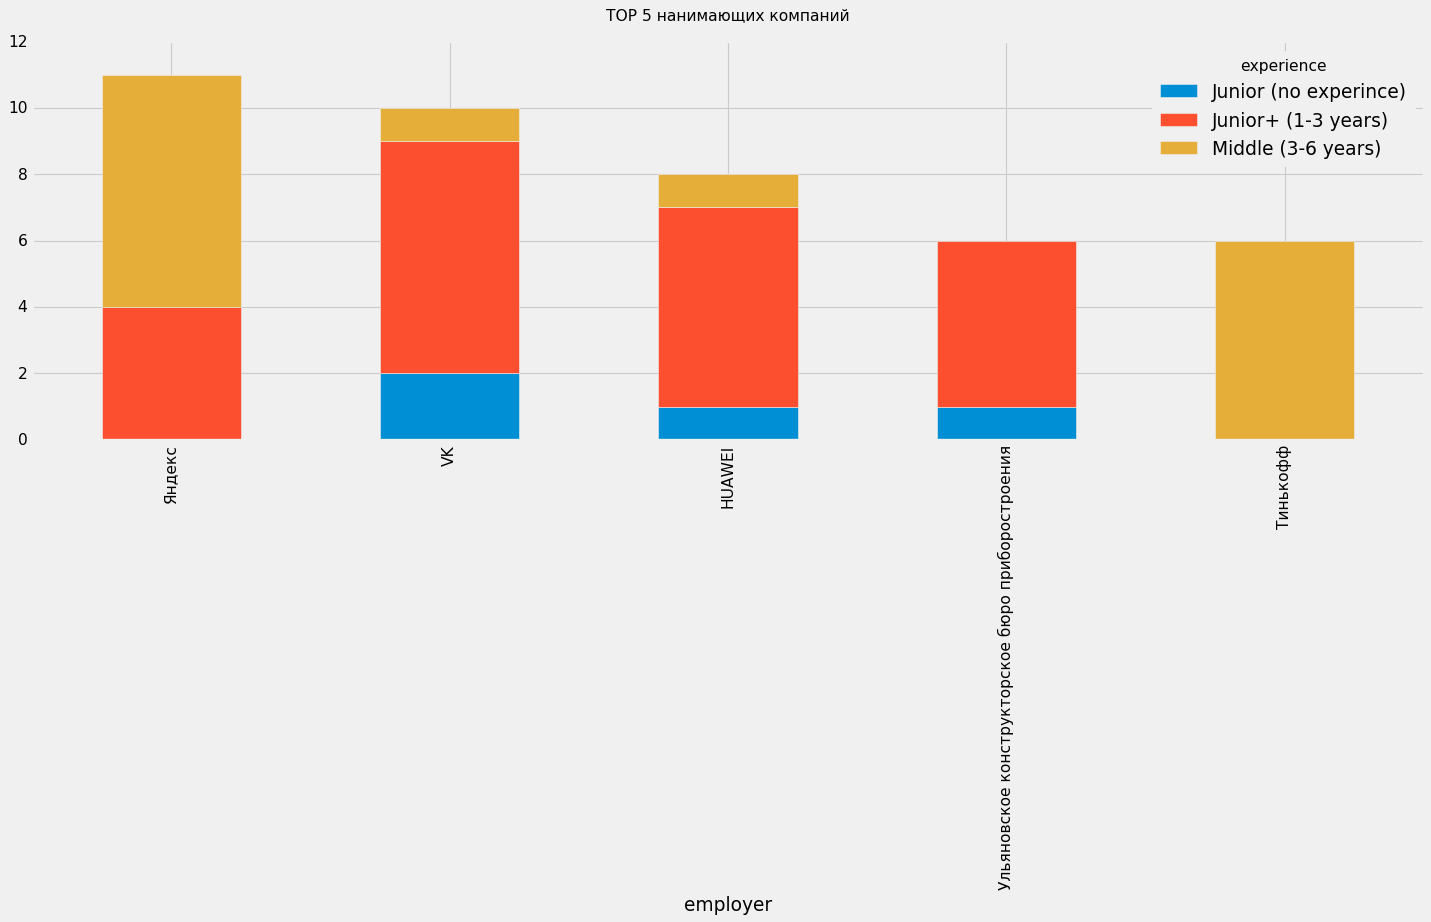

In [282]:
# TOP 5 нанимающих компаний

sorted_5 = df.groupby(['employer']).size().sort_values(ascending=False)[:5]
grouped = df[df['employer'].isin(sorted_5.index.tolist())].groupby(['employer', 'experience']).size()
grouped.reindex(index=sorted_5.index, level=0).unstack().plot(kind='bar', 
                                                              figsize=(20, 6), 
                                                              stacked=True)

plt.title('TOP 5 нанимающих компаний', fontsize=14, pad=20)
plt.show()

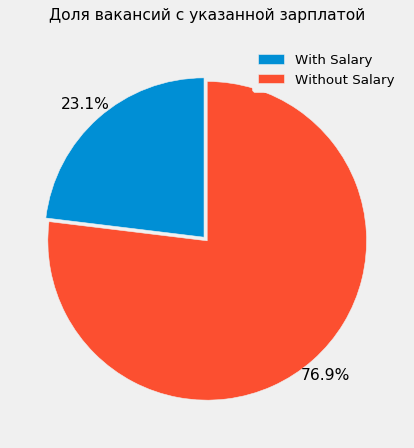

In [283]:
# Доля вакансий с указанной зарплатой

df_with_salary = df[(~df['salary_from'].isnull()) | (~df['salary_to'].isnull())]
df_wo_salary = df[(df['salary_from'].isnull()) & (df['salary_to'].isnull())]

labels = ['With Salary', 'Without Salary']
patches, texts, pcts = plt.pie([len(df_with_salary.index), len(df_wo_salary.index)],
                               autopct='%.1f%%', textprops={'size': 'medium'}, 
                               startangle=90, pctdistance=1.12, explode=[0.03, 0])

plt.rcParams['figure.figsize'] = (20, 6)
plt.title('Доля вакансий с указанной зарплатой', fontsize=14, pad=20)
plt.legend(labels=labels, loc='upper right', fontsize=12)

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'boxes': [<matplotlib.lines.Line2D at 0x7f4c54096790>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4c53ef0d50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f4c53ebe5d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f4c53ebe090>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f4c58e3eb10>,
  <matplotlib.lines.Line2D at 0x7f4c53ee8d50>]}

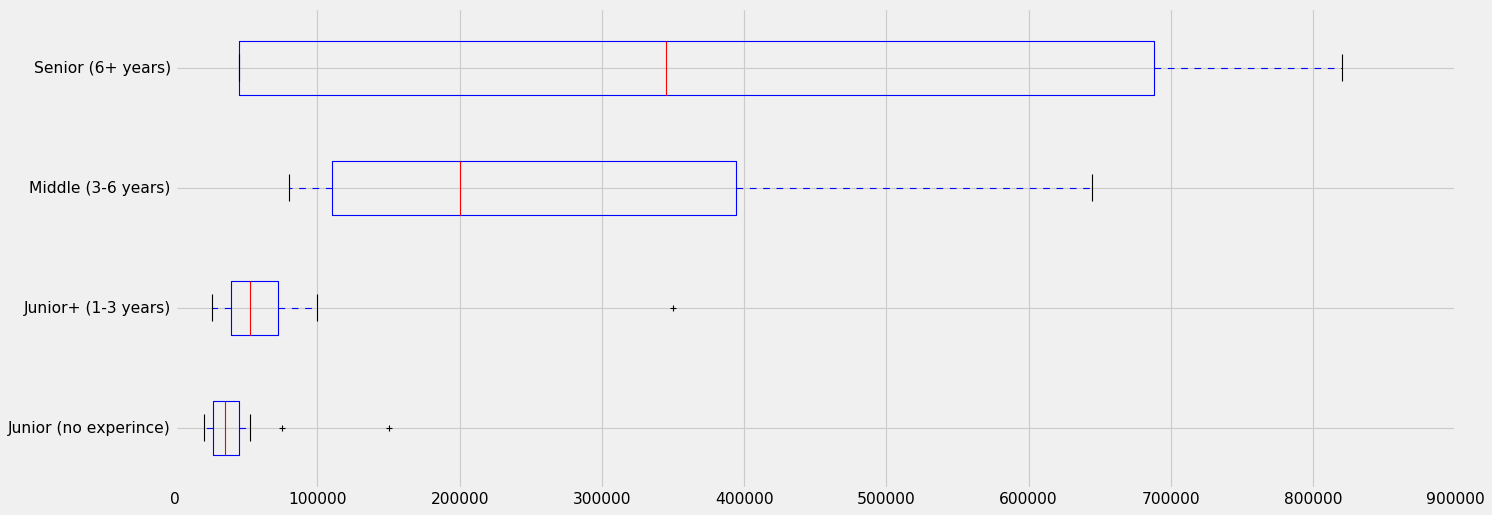

In [284]:
# Аналитика зарплат

df_tmp = df_with_salary[df_with_salary['experience'] == 'Junior (no experince)']
s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
jun_salary = s_tmp[~s_tmp.isnull()]

df_tmp = df_with_salary[df_with_salary['experience'] == 'Junior+ (1-3 years)']
s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
jun_plus_salary = s_tmp[~s_tmp.isnull()]

df_tmp = df_with_salary[df_with_salary['experience'] == 'Middle (3-6 years)']
s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
middle_salary = s_tmp[~s_tmp.isnull()]

df_tmp = df_with_salary[df_with_salary['experience'] == 'Senior (6+ years)']
s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
senior_salary = s_tmp[~s_tmp.isnull()]


fig = plt.figure(figsize =(16, 6))
ax = fig.add_axes([0, 0, 1, 1])

labels = ['Junior (no experince)', 'Junior+ (1-3 years)',
          'Middle (3-6 years)', 'Senior (6+ years)']

ax.boxplot([jun_salary, jun_plus_salary, middle_salary, senior_salary], 
           labels=labels, vert=False)

In [285]:
def get_summary_salary(dataset: pd.Series, exp: str) -> pd.DataFrame:
    
    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.median(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)
    quartile_1 = np.round(dataset.quantile(0.25), 2)
    quartile_3 = np.round(dataset.quantile(0.75), 2)

    # Interquartile range
    iqr = np.round(quartile_3 - quartile_1, 2)
    
    details = {
        'Min': min_value,
        'Mean': mean,
        'Max': max_value,
        '25th percentile': quartile_1,
        'Median': median,
        '75th percentile': quartile_3,
        'Interquartile range (IQR)': iqr
    }

    return pd.DataFrame(details, index=[exp])

In [286]:
salaries = []

salaries.append(get_summary_salary(jun_salary, 'Junior (no experince)'))
salaries.append(get_summary_salary(jun_plus_salary, 'Junior+ (1-3 years)'))
salaries.append(get_summary_salary(middle_salary, 'Middle (3-6 years)'))
salaries.append(get_summary_salary(senior_salary, 'Senior (6+ years)'))

df_salaries = pd.concat(salaries)
df_salaries

,Min,Mean,Max,25th percentile,Median,75th percentile,Interquartile range (IQR)
Junior (no experince),20000.0,43383.33,150000.0,26250.0,35000.00,45000.00,18750.00
Junior+ (1-3 years),26000.0,68637.50,350000.0,39375.0,52500.00,72500.00,33125.00
Middle (3-6 years),80000.0,276201.36,644605.5,110000.0,200000.00,394402.00,284402.00
Senior (6+ years),44922.0,388714.12,820407.0,44922.0,344763.75,688555.88,643633.88
